Epoch 1/100, Loss: 0.002297708299010992
Epoch 2/100, Loss: -0.009861605241894722
Epoch 3/100, Loss: -0.015337184071540833
Epoch 4/100, Loss: -0.01651117578148842
Epoch 5/100, Loss: -0.017496032640337944
Epoch 6/100, Loss: -0.021648315712809563
Epoch 7/100, Loss: -0.02557343989610672
Epoch 8/100, Loss: -0.03121868707239628
Epoch 9/100, Loss: -0.033913638442754745
Epoch 10/100, Loss: -0.03312987461686134
Epoch 11/100, Loss: -0.03447793424129486
Epoch 12/100, Loss: -0.03719821199774742
Epoch 13/100, Loss: -0.04189126938581467
Epoch 14/100, Loss: -0.04495067149400711
Epoch 15/100, Loss: -0.046006083488464355
Epoch 16/100, Loss: -0.046922825276851654
Epoch 17/100, Loss: -0.04915695637464523
Epoch 18/100, Loss: -0.052268482744693756
Epoch 19/100, Loss: -0.05336678773164749
Epoch 20/100, Loss: -0.05476795509457588
Epoch 21/100, Loss: -0.05594280734658241
Epoch 22/100, Loss: -0.05750768631696701
Epoch 23/100, Loss: -0.05931619927287102
Epoch 24/100, Loss: -0.06019987910985947
Epoch 25/100, Los

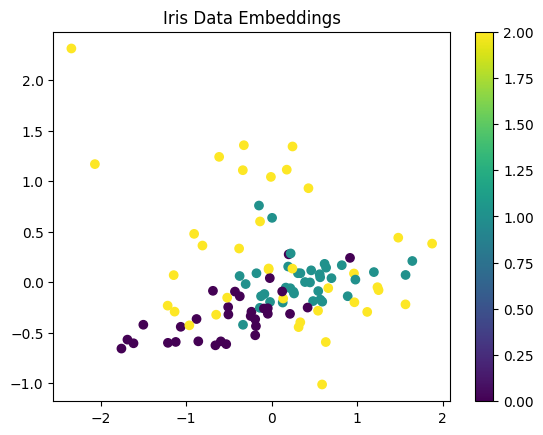

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# データのロードと前処理
iris = load_iris()
X = iris['data']
y = iris['target']

# データを標準化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# PyTorchテンソルに変換
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# シンプルなニューラルネットワーク
class SimpleNN(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, embedding_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# カスタム類似度関数
def custom_similarity(A, B, alpha=0.5, beta=0.5):
    norm_A = torch.norm(A, dim=1)
    norm_B = torch.norm(B, dim=1)
    
    # ゼロベクトルの処理
    if torch.all(norm_A == 0) and torch.all(norm_B == 0):
        return torch.tensor(1.0)
    elif torch.any(norm_A == 0) or torch.any(norm_B == 0):
        return torch.tensor(0.0)

    # コサイン類似度を計算して0~1に変換
    cosine_sim = torch.sum(A * B, dim=1) / (norm_A * norm_B)
    transformed_cosine_sim = (1 + cosine_sim) / 2
    
    # 大きさの類似度
    size_similarity = torch.min(norm_A, norm_B) / torch.max(norm_A, norm_B)
    
    # 総合スコア
    similarity_score = alpha * transformed_cosine_sim + beta * size_similarity
    return similarity_score

# SimCLR風の損失関数
def simclr_loss(embeddings, temperature=0.5):
    n = embeddings.size(0)
    
    # 類似度行列を計算
    similarity_matrix = torch.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                similarity_matrix[i, j] = custom_similarity(embeddings[i:i+1], embeddings[j:j+1])
    
    # 損失の計算 (シンプル化されたコントラスト損失)
    loss = 0
    for i in range(n):
        pos_similarity = similarity_matrix[i, i-1]  # 正例 (隣り合うサンプルを正例とする)
        neg_similarity = similarity_matrix[i].mean()  # 負例 (全体平均を負例とする)
        
        loss += -torch.log(torch.exp(pos_similarity / temperature) / (torch.exp(neg_similarity / temperature)))
    
    return loss / n

# モデルの初期化
model = SimpleNN(input_dim=X_train.shape[1], embedding_dim=64)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# トレーニングループ
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    embeddings = model(X_train)
    loss = simclr_loss(embeddings)
    
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# 埋め込みの可視化（t-SNEやPCAを使用可能）
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

model.eval()
with torch.no_grad():
    embeddings = model(X_train).detach().numpy()

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('Iris Data Embeddings')
plt.show()


In [18]:
i = 0
j=1
a = np.linalg.norm(train_embeddings[y_train == i], axis=1) # (n_i,)
b = np.linalg.norm(train_embeddings[y_train == j], axis=1)  # (n_j,)

# a, bのすべての組の最小値を取得
min_ab = np.minimum.outer(a, b)  # (n_i, n_j)
print(min_ab)
print(min(a[10], b[10]))
print(min_ab[10, 10])

[[0.3860638  0.3860638  0.12853278 ... 0.3860638  0.3860638  0.3860638 ]
 [0.40790612 0.38779396 0.12853278 ... 0.40790612 0.40790612 0.40790612]
 [0.5458824  0.38779396 0.12853278 ... 0.44355503 0.40803322 0.5458824 ]
 ...
 [0.6257506  0.38779396 0.12853278 ... 0.44355503 0.40803322 0.5470403 ]
 [0.42314437 0.38779396 0.12853278 ... 0.42314437 0.40803322 0.42314437]
 [0.6257506  0.38779396 0.12853278 ... 0.44355503 0.40803322 0.5470403 ]]
0.5300679
0.5300679


In [19]:
cosine_similarity(train_embeddings[y_train == i], train_embeddings[y_train == j]).shape

(31, 37)

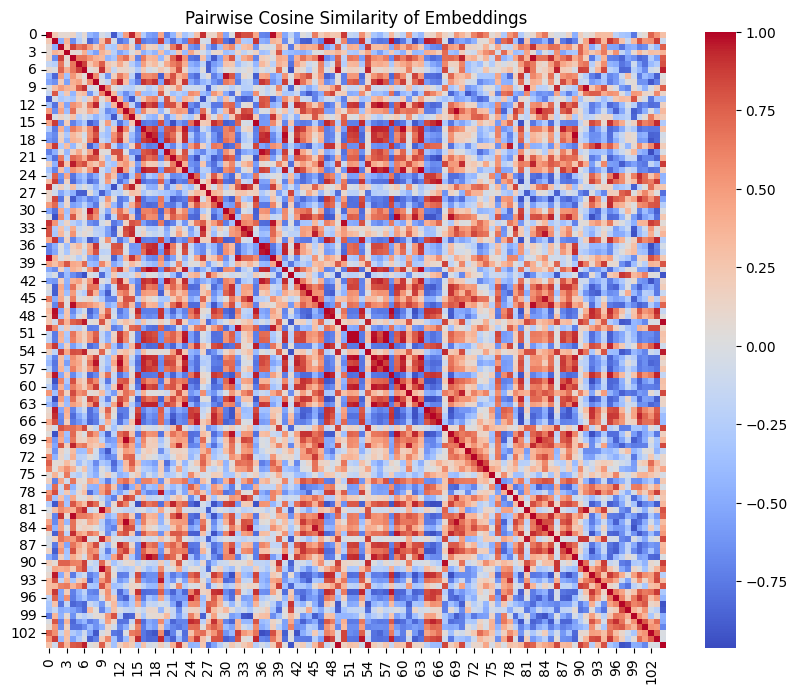

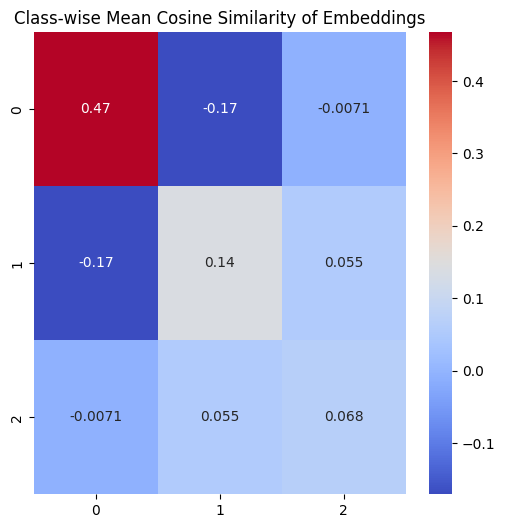

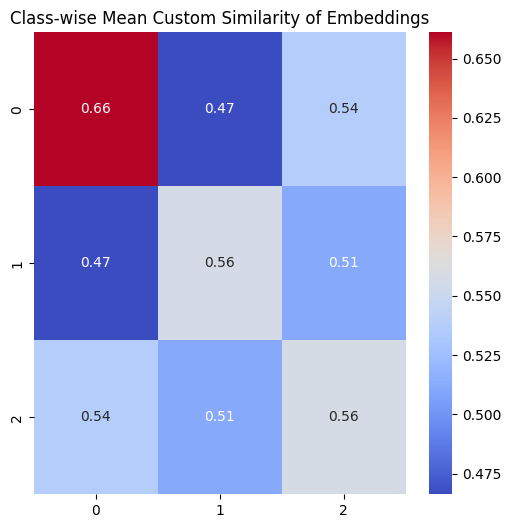

In [20]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# 学習済みの埋め込みを得る
model.eval()
with torch.no_grad():
    train_embeddings = model(X_train).cpu().numpy()
    test_embeddings = model(X_test).cpu().numpy()

# 埋め込みベクトル間のコサイン類似度を計算
similarity_matrix = cosine_similarity(train_embeddings)

# 類似度行列をヒートマップで可視化
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='coolwarm', annot=False)
plt.title('Pairwise Cosine Similarity of Embeddings')
plt.show()

# トレーニングデータにおけるクラスごとの他のクラスサンプルとの類似度の平均を計算
#{0: {0: 0.9999999999999999, 1: 0.9999999999999999, 2: 0.9999999999999999},1: {...}, 2: {...}}のような形
class_similarity = {}
for i in range(3):
    class_similarity[i] = {}
    for j in range(3):
        class_similarity[i][j] = similarity_matrix[y_train == i][:, y_train == j].mean()

# クラスごとの他のクラスサンプルとの類似度の平均をヒートマップで可視化
plt.figure(figsize=(6, 6))
sns.heatmap([[class_similarity[0][0], class_similarity[
    0][1], class_similarity[0][2]], [class_similarity[1][0], class_similarity[1][1], class_similarity[1][2]], [class_similarity[2][0], class_similarity[2][1], class_similarity[2][2]]], cmap='coolwarm', annot=True)
plt.title('Class-wise Mean Cosine Similarity of Embeddings')
plt.show()

# トレーニングデータにおけるクラスごとの他のクラスサンプルとのカスタム類似度関数の平均を計算
class_similarity = {}
for i in range(3):
    class_similarity[i] = {}
    for j in range(3):
        cossim = cosine_similarity(train_embeddings[y_train == i], train_embeddings[y_train == j])
        cossim = 1 + cossim
        cossim /= 2
        min_comb = np.minimum.outer(np.linalg.norm(train_embeddings[y_train == i], axis=1), np.linalg.norm(train_embeddings[y_train == j], axis=1))
        max_comb = np.maximum.outer(np.linalg.norm(train_embeddings[y_train == i], axis=1), np.linalg.norm(train_embeddings[y_train == j], axis=1))
        ratio = min_comb / max_comb
        class_similarity[i][j] = np.mean(0.5 * cossim + 0.5 * ratio)
    

# クラスごとの他のクラスサンプルとのカスタム類似度関数の平均をヒートマップで可視化
plt.figure(figsize=(6, 6))
sns.heatmap([[class_similarity[0][0], class_similarity[
    0][1], class_similarity[0][2]], [class_similarity[1][0], class_similarity[1][1], class_similarity[1][2]], [class_similarity[2][0], class_similarity[2][1], class_similarity[2][2]]], cmap='coolwarm', annot=True)
plt.title('Class-wise Mean Custom Similarity of Embeddings')
plt.show()


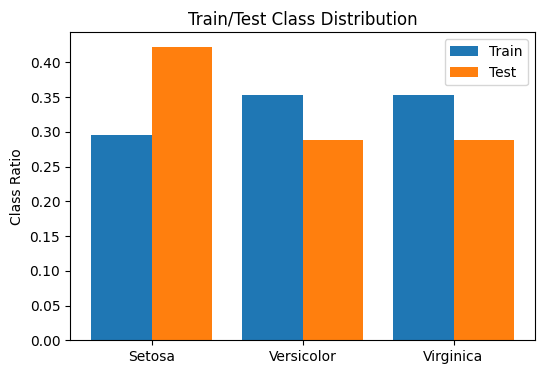

In [21]:
# トレインデータの各クラスのデータ数の割合
train_class_ratios = {}
for i in range(3):
    train_class_ratios[i] = (y_train == i).sum() / len(y_train)

# テストデータの各クラスのデータ数の割合
test_class_ratios = {}
for i in range(3):
    test_class_ratios[i] = (y_test == i).sum() / len(y_test)

# トレーニングデータとテストデータの各クラスのデータ数の割合を比較
plt.figure(figsize=(6, 4))
plt.bar(np.array(list(train_class_ratios.keys())) - 0.2, list(train_class_ratios.values()), width=0.4, label='Train')
plt.bar(np.array(list(test_class_ratios.keys())) + 0.2, list(test_class_ratios.values()), width=0.4, label='Test')
plt.xticks(range(3), ['Setosa', 'Versicolor', 'Virginica'])
plt.ylabel('Class Ratio')
plt.title('Train/Test Class Distribution')
plt.legend()
plt.show()

In [1]:
import torch 
torch.cuda.is_available()

True

Using device: cuda
Epoch 1/50, Loss: 0.007728469092398882
Epoch 2/50, Loss: 0.0024107128847390413
Epoch 3/50, Loss: -0.00438826996833086
Epoch 4/50, Loss: -0.007501416373997927
Epoch 5/50, Loss: -0.012921880930662155
Epoch 6/50, Loss: -0.017561839893460274
Epoch 7/50, Loss: -0.019241543486714363
Epoch 8/50, Loss: -0.02230198122560978
Epoch 9/50, Loss: -0.025211498141288757
Epoch 10/50, Loss: -0.027882881462574005
Epoch 11/50, Loss: -0.027524374425411224
Epoch 12/50, Loss: -0.029728520661592484
Epoch 13/50, Loss: -0.03294618800282478
Epoch 14/50, Loss: -0.03391653299331665
Epoch 15/50, Loss: -0.03495502099394798
Epoch 16/50, Loss: -0.036123692989349365
Epoch 17/50, Loss: -0.03720401972532272
Epoch 18/50, Loss: -0.039079450070858
Epoch 19/50, Loss: -0.04124389961361885
Epoch 20/50, Loss: -0.04292496293783188
Epoch 21/50, Loss: -0.04416879639029503
Epoch 22/50, Loss: -0.045627955347299576
Epoch 23/50, Loss: -0.04714164882898331
Epoch 24/50, Loss: -0.04898082837462425
Epoch 25/50, Loss: -0

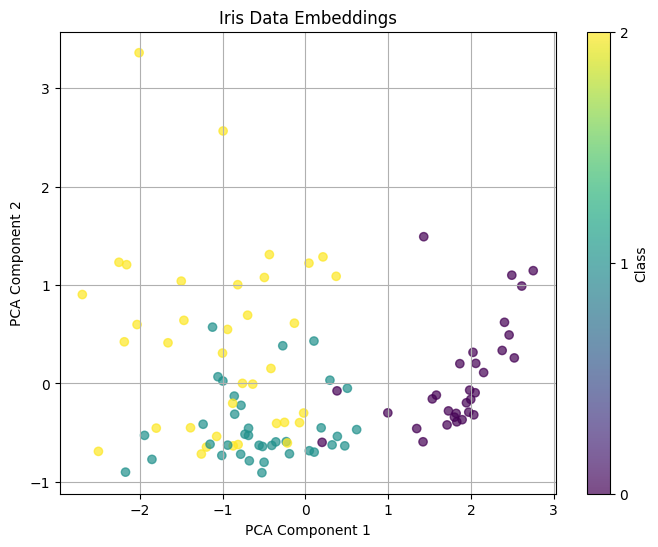

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# GPUの確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# データのロードと前処理
iris = load_iris()
X = iris['data']
y = iris['target']

# データを標準化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# PyTorchテンソルに変換し、デバイスに移動
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)

# シンプルなニューラルネットワーク
class SimpleNN(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, embedding_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# カスタム類似度関数
def custom_similarity(A, B, alpha=0.5, beta=0.5):
    norm_A = torch.norm(A, dim=1)
    norm_B = torch.norm(B, dim=1)
    
    # ゼロベクトルの処理
    if torch.all(norm_A == 0) and torch.all(norm_B == 0):
        return torch.tensor(1.0, device=device)
    elif torch.any(norm_A == 0) or torch.any(norm_B == 0):
        return torch.tensor(0.0, device=device)

    # コサイン類似度を計算して0~1に変換
    cosine_sim = torch.sum(A * B, dim=1) / (norm_A * norm_B)
    transformed_cosine_sim = (1 + cosine_sim) / 2
    
    # 大きさの類似度
    size_similarity = torch.min(norm_A, norm_B) / torch.max(norm_A, norm_B)
    
    # 総合スコア
    similarity_score = alpha * transformed_cosine_sim + beta * size_similarity
    return similarity_score

# SimCLR風の損失関数
def simclr_loss(embeddings, temperature=0.5):
    n = embeddings.size(0)
    
    # 類似度行列を計算
    similarity_matrix = torch.zeros((n, n), device=device)
    for i in range(n):
        for j in range(n):
            if i != j:
                similarity_matrix[i, j] = custom_similarity(embeddings[i:i+1], embeddings[j:j+1])
    
    # 損失の計算 (シンプル化されたコントラスト損失)
    loss = 0
    for i in range(n):
        pos_similarity = similarity_matrix[i, i-1]  # 正例 (隣り合うサンプルを正例とする)
        neg_similarity = similarity_matrix[i].mean()  # 負例 (全体平均を負例とする)
        
        loss += -torch.log(torch.exp(pos_similarity / temperature) / (torch.exp(neg_similarity / temperature)))
    
    return loss / n

# モデルの初期化
model = SimpleNN(input_dim=X_train.shape[1], embedding_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# トレーニングループ
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    embeddings = model(X_train)
    loss = simclr_loss(embeddings)
    
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# 埋め込みの可視化（PCAを使用）
model.eval()
with torch.no_grad():
    embeddings = model(X_train).detach().cpu().numpy()  # CPUに戻す

# PCAで2次元に圧縮
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# 分類ごとにプロット
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_train.cpu().numpy(), cmap='viridis', alpha=0.7)
plt.colorbar(scatter, ticks=[0, 1, 2], label='Class')
plt.title('Iris Data Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()


In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

a = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15], [16, 17, 18], [19, 20, 21], [22, 23, 24], [25, 26, 27], [28, 29, 30]]
b = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [-28, -29, -30]]

cos = cosine_similarity(a, b)
print(cos.shape)
min_dist = np.minimum.outer(np.linalg.norm(a, axis=1), np.linalg.norm(b, axis=1))
print(min_dist.shape)
max_dist = np.maximum.outer(np.linalg.norm(a, axis=1), np.linalg.norm(b, axis=1))
print(max_dist.shape)
ratio_dist = min_dist / max_dist
print(ratio_dist.shape)
weight_sim = 0.5 * (1 + cos)/2 + 0.5 * ratio_dist
print(weight_sim.shape)

(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)


In [2]:
(cos + 1)/2

array([[1.00000000e+00, 9.87315923e-01, 9.79705973e-01, 3.19546196e-02],
       [9.87315923e-01, 1.00000000e+00, 9.99095446e-01, 4.46379846e-03],
       [9.79705973e-01, 9.99095446e-01, 1.00000000e+00, 1.35224195e-03],
       [9.75629154e-01, 9.98074928e-01, 9.99809313e-01, 5.27607815e-04],
       [9.73127762e-01, 9.97318365e-01, 9.99527997e-01, 2.26599426e-04],
       [9.71443267e-01, 9.96761439e-01, 9.99278779e-01, 9.84499162e-05],
       [9.70233519e-01, 9.96340085e-01, 9.99072849e-01, 4.00338921e-05],
       [9.69323254e-01, 9.96011982e-01, 9.98903965e-01, 1.34590475e-05],
       [9.68613779e-01, 9.95749962e-01, 9.98764407e-01, 2.63376785e-06],
       [9.68045380e-01, 9.95536202e-01, 9.98647758e-01, 0.00000000e+00]])

In [3]:
min_dist

array([[ 3.74165739,  3.74165739,  3.74165739,  3.74165739],
       [ 3.74165739,  8.77496439,  8.77496439,  8.77496439],
       [ 3.74165739,  8.77496439, 13.92838828, 13.92838828],
       [ 3.74165739,  8.77496439, 13.92838828, 19.10497317],
       [ 3.74165739,  8.77496439, 13.92838828, 24.2899156 ],
       [ 3.74165739,  8.77496439, 13.92838828, 29.47880595],
       [ 3.74165739,  8.77496439, 13.92838828, 34.66987165],
       [ 3.74165739,  8.77496439, 13.92838828, 39.86226286],
       [ 3.74165739,  8.77496439, 13.92838828, 45.0555213 ],
       [ 3.74165739,  8.77496439, 13.92838828, 50.24937811]])

In [4]:
max_dist

array([[ 3.74165739,  8.77496439, 13.92838828, 50.24937811],
       [ 8.77496439,  8.77496439, 13.92838828, 50.24937811],
       [13.92838828, 13.92838828, 13.92838828, 50.24937811],
       [19.10497317, 19.10497317, 19.10497317, 50.24937811],
       [24.2899156 , 24.2899156 , 24.2899156 , 50.24937811],
       [29.47880595, 29.47880595, 29.47880595, 50.24937811],
       [34.66987165, 34.66987165, 34.66987165, 50.24937811],
       [39.86226286, 39.86226286, 39.86226286, 50.24937811],
       [45.0555213 , 45.0555213 , 45.0555213 , 50.24937811],
       [50.24937811, 50.24937811, 50.24937811, 50.24937811]])

In [5]:
ratio_dist

array([[1.        , 0.42640143, 0.26863534, 0.07446177],
       [0.42640143, 1.        , 0.63000573, 0.17462832],
       [0.26863534, 0.63000573, 1.        , 0.27718529],
       [0.1958473 , 0.45930263, 0.72904516, 0.38020318],
       [0.1540416 , 0.36125957, 0.57342267, 0.48338739],
       [0.12692703, 0.29767028, 0.47248821, 0.58665016],
       [0.10792245, 0.25310057, 0.40174329, 0.68995623],
       [0.09386465, 0.22013212, 0.34941289, 0.79328868],
       [0.08304548, 0.19475891, 0.30913832, 0.89663839],
       [0.07446177, 0.17462832, 0.27718529, 1.        ]])

In [6]:
weight_sim

array([[1.        , 0.70685868, 0.62417066, 0.05320819],
       [0.70685868, 1.        , 0.81455059, 0.08954606],
       [0.62417066, 0.81455059, 1.        , 0.13926876],
       [0.58573823, 0.72868878, 0.86442724, 0.19036539],
       [0.56358468, 0.67928897, 0.78647533, 0.24180699],
       [0.54918515, 0.64721586, 0.7358835 , 0.29337431],
       [0.53907798, 0.62472033, 0.70040807, 0.34499813],
       [0.53159395, 0.60807205, 0.67415843, 0.39665107],
       [0.52582963, 0.59525444, 0.65395136, 0.44832051],
       [0.52125357, 0.58508226, 0.63791652, 0.5       ]])

In [3]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

a = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15], [16, 17, 18], [19, 20, 21], [22, 23, 24], [25, 26, 27], [28, 29, 30]]
b = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [-28, -29, -30]]
# b = [[-28, -29, -30]]


cos = cosine_similarity(a, b)
min_dist = np.minimum.outer(np.linalg.norm(a, axis=1), np.linalg.norm(b, axis=1))
max_dist = np.maximum.outer(np.linalg.norm(a, axis=1), np.linalg.norm(b, axis=1))
ratio_dist = min_dist / max_dist
weight_sim = 0.5 * (1 + cos)/2 + 0.5 * ratio_dist
weight_sim = weight_sim.T

# weight_simを距離指標としてbの各データのaに対するknnを計算
print(weight_sim)
knn = np.sort(weight_sim, axis=1)[:, -2:]
print(knn)
knn = np.mean(knn, axis=1)
print(knn)

[[1.         0.70685868 0.62417066 0.58573823 0.56358468 0.54918515
  0.53907798 0.53159395 0.52582963 0.52125357]
 [0.70685868 1.         0.81455059 0.72868878 0.67928897 0.64721586
  0.62472033 0.60807205 0.59525444 0.58508226]
 [0.62417066 0.81455059 1.         0.86442724 0.78647533 0.7358835
  0.70040807 0.67415843 0.65395136 0.63791652]
 [0.05320819 0.08954606 0.13926876 0.19036539 0.24180699 0.29337431
  0.34499813 0.39665107 0.44832051 0.5       ]]
[[0.70685868 1.        ]
 [0.81455059 1.        ]
 [0.86442724 1.        ]
 [0.44832051 0.5       ]]
[0.85342934 0.90727529 0.93221362 0.47416026]


In [5]:
1 - np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15], [16, 17, 18], [19, 20, 21], [22, 23, 24], [25, 26, 27], [28, 29, 30]])

array([[  0,  -1,  -2],
       [ -3,  -4,  -5],
       [ -6,  -7,  -8],
       [ -9, -10, -11],
       [-12, -13, -14],
       [-15, -16, -17],
       [-18, -19, -20],
       [-21, -22, -23],
       [-24, -25, -26],
       [-27, -28, -29]])

In [31]:
cos# weight_simを距離指標としてbの各データのaに対するknnを計算
cos= (cos.T + 1) / 2
print(cos)
knn = np.sort(cos, axis=1)[:, -2:]
print(knn)
knn = np.mean(knn, axis=1)
print(knn)

[[1.00000000e+00 9.87315923e-01 9.79705973e-01 9.75629154e-01
  9.73127762e-01 9.71443267e-01 9.70233519e-01 9.69323254e-01
  9.68613779e-01 9.68045380e-01]
 [9.87315923e-01 1.00000000e+00 9.99095446e-01 9.98074928e-01
  9.97318365e-01 9.96761439e-01 9.96340085e-01 9.96011982e-01
  9.95749962e-01 9.95536202e-01]
 [9.79705973e-01 9.99095446e-01 1.00000000e+00 9.99809313e-01
  9.99527997e-01 9.99278779e-01 9.99072849e-01 9.98903965e-01
  9.98764407e-01 9.98647758e-01]
 [3.19546196e-02 4.46379846e-03 1.35224195e-03 5.27607815e-04
  2.26599426e-04 9.84499162e-05 4.00338921e-05 1.34590475e-05
  2.63376785e-06 0.00000000e+00]]
[[0.98731592 1.        ]
 [0.99909545 1.        ]
 [0.99980931 1.        ]
 [0.0044638  0.03195462]]
[0.99365796 0.99954772 0.99990466 0.01820921]


In [29]:
ratio = ratio_dist.T
print(ratio)
knn = np.sort(ratio, axis=1)[:, -2:]
print(knn)
knn = np.mean(knn, axis=1)
print(knn)

[[1.         0.42640143 0.26863534 0.1958473  0.1540416  0.12692703
  0.10792245 0.09386465 0.08304548 0.07446177]
 [0.42640143 1.         0.63000573 0.45930263 0.36125957 0.29767028
  0.25310057 0.22013212 0.19475891 0.17462832]
 [0.26863534 0.63000573 1.         0.72904516 0.57342267 0.47248821
  0.40174329 0.34941289 0.30913832 0.27718529]
 [0.07446177 0.17462832 0.27718529 0.38020318 0.48338739 0.58665016
  0.68995623 0.79328868 0.89663839 1.        ]]
[[0.42640143 1.        ]
 [0.63000573 1.        ]
 [0.72904516 1.        ]
 [0.89663839 1.        ]]
[0.71320072 0.81500286 0.86452258 0.94831919]


In [3]:
# K個の最近傍（ユークリッド距離）の平均を取得
import numpy as np
from sklearn.neighbors import NearestNeighbors

a = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15], [16, 17, 18], [19, 20, 21], [22, 23, 24], [25, 26, 27], [28, 29, 30]] 
b = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [-28, -29, -30]]

# モデルの初期化
k = 2
nn = NearestNeighbors(n_neighbors=k, metric='euclidean')
nn.fit(a)

# bの各データに対する最近傍の距離とインデックスを取得
distances, indices = nn.kneighbors(b)
# distances = np.mean(distances, axis=1)
print(np.array(distances).shape)

(4, 2)


In [15]:
a = [10, 21, 3]
dic = {"A": 1, "B": 2, "C": 3}
print(dic)

#リストaの値が多きい順にdicのkeyをソート
sorted(dic, key=dic.get, reverse=True)

{'A': 1, 'B': 2, 'C': 3}


['C', 'B', 'A']